In [2]:
import itertools
import random
import yaml

import numpy as np
import pandas as pd
import seaborn as sn

In [3]:
# Move project root folder
%cd ..

/Users/mwtmurphy/projects/f1-elo


/Users/mwtmurphy/Library/Caches/pypoetry/virtualenvs/f1-elo-tRE7S7Hg-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
with open("params.yaml") as conf_file:
    CONFIG = yaml.safe_load(conf_file)

In [5]:
c = 400 # scaling factor
k = 24 # maximum possible adjustment per game
w = 1 # team weighting

In [6]:
cle_df = pd.read_csv(CONFIG["data"]["features_path"])
cle_df["prevRaces"] = cle_df.groupby("driverId").cumcount()

# Elo calculation for expectation - introducing constructor scores

In [7]:
dri_scores = {id: CONFIG["model"]["start_score"] for id in set(cle_df["driverId"])}
con_scores = {id: CONFIG["model"]["start_score"] for id in set(cle_df["constructorId"])}
cle_df[["constructorScore", "driverScore"]] = None
results = []
yr_df = cle_df[["year", "round"]].drop_duplicates()

for _, (yr, rnd) in yr_df.iterrows():
    valid_ix = (cle_df["year"] == yr) & (cle_df["round"] == rnd)
    rnd_dri_scores = {dri: {"diff": 0, "n": 0} for dri in cle_df.loc[valid_ix, "driverId"]}
    rnd_con_scores = {dri: {"diff": 0, "n": 0} for dri in cle_df.loc[valid_ix, "constructorId"]}

    for ix_1, ix_2 in itertools.combinations(cle_df[valid_ix].index, 2):
        dri_a = cle_df.loc[ix_1, "driverId"]
        con_a = cle_df.loc[ix_1, "constructorId"]
        elo_a = dri_scores[dri_a] + (w * con_scores[con_a])
        pos_a = cle_df.loc[ix_1, "mapPosition"]

        dri_b = cle_df.loc[ix_2, "driverId"]
        con_b = cle_df.loc[ix_2, "constructorId"]
        elo_b = dri_scores[dri_b] + (w * con_scores[con_b])
        pos_b = cle_df.loc[ix_2, "mapPosition"]

        # continue if drivers in same car
        if pos_a == pos_b:
            continue

        # calculate position influence
        q_a = 10 ** (elo_a / c)
        q_b = 10 ** (elo_b / c)

        e_a = q_a / (q_a + q_b)        
        e_b = q_b / (q_a + q_b)

        # score outcome
        if pos_a < pos_b:
            o_a = 1
            o_b = 0
        else:
            o_a = 0
            o_b = 1
            
        # calculate score change and update round scores
        diff_a = k * (o_a - e_a)
        diff_b = k * (o_b - e_b)

        results.append({
            "elo_a": elo_a,
            "pr_a": cle_df.loc[ix_1, "prevRaces"],
            "elo_b": elo_b,
            "pr_b": cle_df.loc[ix_2, "prevRaces"],
            "o_a": o_a,
            "e_a": e_a,
            "o_b": o_b,
            "e_b": e_b
        })

        rnd_con_scores[con_a]["diff"] += diff_a
        rnd_con_scores[con_a]["n"] += 1
        rnd_dri_scores[dri_a]["diff"] += diff_a
        rnd_dri_scores[dri_a]["n"] += 1

        rnd_con_scores[con_b]["diff"] += diff_b
        rnd_con_scores[con_b]["n"] += 1
        rnd_dri_scores[dri_b]["diff"] += diff_b
        rnd_dri_scores[dri_b]["n"] += 1

    for dri in rnd_dri_scores.keys():
        dri_scores[dri] += (rnd_dri_scores[dri]["diff"] / rnd_dri_scores[dri]["n"])
    
    for con in rnd_con_scores.keys():
        con_scores[con] += (rnd_con_scores[con]["diff"] / rnd_con_scores[con]["n"])
        
    cle_df.loc[valid_ix, "constructorScore"] = cle_df.loc[valid_ix, "constructorId"].map(con_scores)        
    cle_df.loc[valid_ix, "driverScore"] = cle_df.loc[valid_ix, "driverId"].map(dri_scores)

err_df = pd.DataFrame(results)
err_df["squared_error"] = (err_df["o_a"] - err_df["e_a"]) ** 2
rmse = pow(err_df["squared_error"].sum() / err_df.shape[0], 0.5)
rmse

0.4589874095652029

In [8]:
err_df["elo_diff"] = err_df["elo_a"] - err_df["elo_b"]
err_df["min_races"] = err_df[["pr_a", "pr_b"]].min(axis=1)
err_df.head()

,elo_a,pr_a,elo_b,pr_b,o_a,e_a,o_b,e_b,squared_error,elo_diff,min_races
0,3000.0,0,3000.0,0,1,0.5,0,0.5,0.25,0.0,0
1,3000.0,0,3000.0,0,1,0.5,0,0.5,0.25,0.0,0
2,3000.0,0,3000.0,0,1,0.5,0,0.5,0.25,0.0,0
3,3000.0,0,3000.0,0,1,0.5,0,0.5,0.25,0.0,0
4,3000.0,0,3000.0,0,1,0.5,0,0.5,0.25,0.0,0


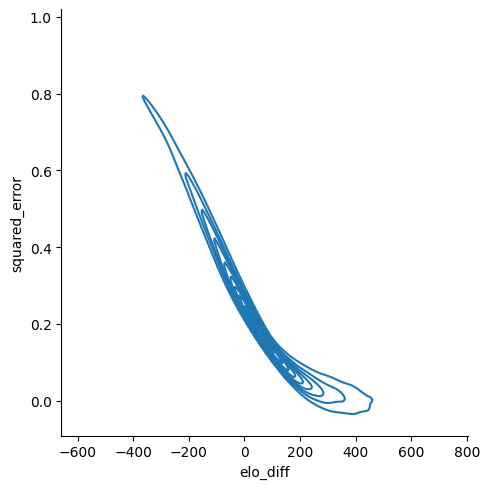

In [9]:
sn.displot(err_df.sample(20000), x="elo_diff", y="squared_error", kind="kde")

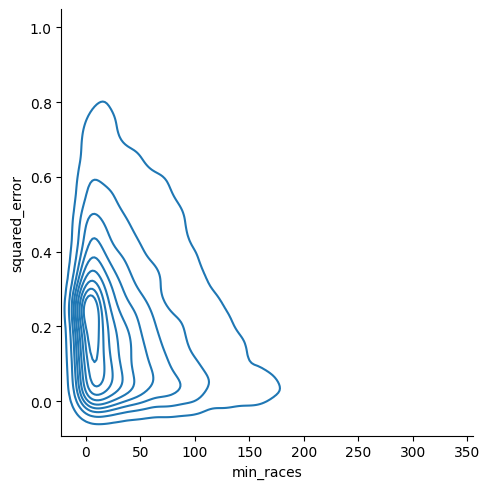

In [10]:
sn.displot(err_df.sample(20000), x="min_races", y="squared_error", kind="kde")